# Manifold Learning on latent space vectors of ClusterGAN

This notebook will be building upon the implementation of [ClusterGAN](https://github.com/zhampel/clusterGAN) by [Zigfried Hampel-Arias](https://github.com/zhampel), based on this paper on ClusterGAN [ClusterGAN](https://arxiv.org/abs/1809.03627)

This research hope to use various types of Mathematical Optimization techniques to model the learned latent space vectors of the CLusterGAN variant. This will enable researchers to cluster the latent space vectors appropriately with respect to the number of classes in the image.

<br>

# Interesting Dialogue on the Topic

---


> Here are few commonly asked questions of latent space vectors


<br>

### YOU: **So what's the deal with optimizing mathematically ?** 

Most of the data we have are euclidean in nature. Let's take a simple Dogs-Cats dataset. We put those thousands of such data points into a function approximator ( neural network ) and train on deep CNN classifier. **Peanuts right !**. 

Dozens of batches forward propagating and backward propagating and we have an epoch. A few more epochs later we have an acceptable error value. (Viola we found the lowest error value)

<br>

**Take Case 1:** This Dog-Cat classifier learn what makes an input a dog or a cat

Mathematically: What makes input image X to be of class Y1 (cat) or Y2 (dog)

By optimizing latent space vectors we can understand what makes the hidden representations of an image class similar across other images of same class. (with me ? if not take a look at the example below)

**Take Case 2:** The classifier took an input and wanted to know whether that input is a dog or a cat. But latent spaces of an image ask a different question. It look at a bunch of cat pictures and dogs pictures and asks what makes an input a cat, dog, or dinosaur etc. 

Mathematically: What makes input image X1 and X2 similar OR image X1 and X3 different. What predominant features are present in images of a particular class.

What makes a bunch of dog images similar? OR what features of the images are retained in the saliency maps. 

1.   Is is pointed nose ?
2.   Is it long mouth ? etc.

**In Comparison with classifiers** they ask a question "is this input image a cat or dog"?

**Latent Space vectors** ask a question "what makes 2 or more dog images similar" what are features of cat and dog ?

**BUT** yout get the point right.
That is the fundemental question asked in almost any latent space vector based research. 


---

<br>

### YOU: **What's latent space optimization?**

Latent space vectors are the data structures that store information on WHAT makes an input a cat or a dog. By using mathematical methods to optimized them we can make the network do 2 things

1. Learn WHAT makes the inputs of similar classes.
2. Reveal learned information on classes better.

I'm doing the latter in my research.

<br>

---

<br>

### YOU: "*shuffle nervously*" **Err so what's latent space interpolation?**

I AM Glad you asked. So we left of from the previous question with the idea that the latent spaces learn similar features of a same class.

Ex Dog - long nose, long mouth

Ex Cat - pointed ears, prominent whiskers

By interpolating latent spaces we can give one feature of a class to a another feature.

For Example: We can synthesise ( or generate) an image of a dog with prominent whiskers.

<br>

---

<br>

### YOU: "*smiles*" **Big Deal!! You're making a dog with whiskers LOL.What are other applications ? Giving cats dinosaur bones?**

Dinosaur bones we can discuss later. But think of it. After looking at a bunch of pictures of people. We can interpolate the latent spaces to generate images of people with beards, sunglasses etc.

### YOU: **But why, why would you do tha..**

Alright think of it this way! By generating pics of a person with sunglasses or beards, or maybe aged versions of themselves we can get more data on a person. This will give us more data to train a classifier that recognises faces. By making sure that we have information on how the person might be looking with a beard, or maybe with a different haircut we can make the facial recognition systems more robust. 

This will increase security as facial recognition system is a touchless system, or non invasive system. With other systems like fingerprint access system you have to physically touch the sensor. 

**This will be useful with pandemics such as the COVID-19 as well. We need more robustness in non invasive (touchless) authentication systems.**

<br>

---

<br>

### THIS is only an application of latent space vectors in facial recognition. There are plenty of more applications to latent spaces. 

### This brought about a whole niche area of deep learning called *drumroll* **"Representation Learning"**

# System Configurations

In [0]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 36.7MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
#!top

In [0]:
! nvcc --version
! python -c "import torch; print(torch.version.cuda)"
! python -c "import torch; print(torch.__version__)"
! python -c "import torch; print(torch.cuda.is_available())"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
10.1
1.4.0
True


In [0]:
! PATH=/usr/local/cuda/bin:$PATH
! CPATH=/usr/local/cuda/include:$CPATH    
! LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
! DYLD_LIBRARY_PATH=/usr/local/cuda/lib:$DYLD_LIBRARY_PATH

In [0]:
!nvidia-smi

Fri May  8 20:23:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Load Dependencies

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from itertools import chain as ichain
import time
from IPython.display import clear_output
import sys

# Load Dataset

In [0]:
from torchvision.datasets import MNIST
#https://github.com/Manuel4131/GoMNIST/tree/master/data

data_train = MNIST('~/pytorch_data', train=True, download=True,transform = transforms.Compose(
    [transforms.ToTensor()]))

Extracting /root/pytorch_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/pytorch_data/MNIST/raw


Extracting /root/pytorch_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/pytorch_data/MNIST/raw


Extracting /root/pytorch_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/pytorch_data/MNIST/raw


Extracting /root/pytorch_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/pytorch_data/MNIST/raw
Processing...
Done!





# Preprocess the data

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets

DATASET_FN_DICT = {'mnist' : datasets.MNIST,
                   'fashion-mnist' : datasets.FashionMNIST
                  }


dataset_list = DATASET_FN_DICT.keys()


def get_dataset(dataset_name='mnist'):
    """
    Convenience function for retrieving
    allowed datasets.
    Parameters
    ----------
    name : {'mnist', 'fashion-mnist'}
          Name of dataset
    Returns
    -------
    fn : function
         PyTorch dataset
    """
    if dataset_name in DATASET_FN_DICT:
        fn = DATASET_FN_DICT[dataset_name]
        return fn
    else:
        raise ValueError('Invalid dataset, {}, entered. Must be '
                         'in {}'.format(dataset_name, DATASET_FN_DICT.keys()))



def get_dataloader(dataset_name='mnist', data_dir='', batch_size=64, train_set=True):

    dset = get_dataset(dataset_name)

    dataloader = torch.utils.data.DataLoader(
        dset(data_dir, train=train_set, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=batch_size, shuffle=True)

    return dataloader

In [0]:

def preprocess_img(img):
    """
    Preprocess the images that the are normalized and clipped to a range between -1 and 1
    Input: Batch of images
    Output: Batch of normalized and clipped images
    """
    img = (img.float() / 255- 0.5) * 2
    img = torch.FloatTensor(np.clip(img.numpy(), -1, 1))      
    return img

def deprocess(x):
    """
    Deprocess the normalized vector images back to image format in range 0,255 
    Input: norm image vector with size (1,784)
    Output: image Tensor size (28,28)
    """
    x = (x.detach() / 2 + 1) * 255
    x = torch.clamp(x, min = 0, max = 255)
    return x.view(28,28)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0),*self.shape)

def calc_gradient_penalty(netD, real_data, generated_data):
    """
    
    """
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]
    # Calculate interpolation
    alpha = torch.rand(b_size,1, 1, 1)
    alpha = alpha.expand_as(real_data).to(device)
    if b_size == 32:
        generated_data = generated_data[:32]
    #assert real_data.shape == (64,1,28,28), "real_data is not in 64,1,28,28 shape but rather {} - alpha: {}".format(real_data.shape, alpha.shape)
    #assert alpha.shape == (64,1,28,28), "alpha is not in 64,1,28,28 shape  but rather {} ".format(alpha.shape)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = interpolated.requires_grad_(True)

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return  LAMBDA * ((gradients_norm - 1.0) ** 2).mean()

def plot(frame_idx, z_error, X_error):
    """
    Plots: || z - E(G(z))||
    and    || X - G(E(X))||
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("Cycle L2-distance loss")
    plt.plot(z_error, label = "|| z - E(G(z))||", color = "r")
    plt.plot(X_error, label = "|| X - G(E(X))||", color = "b")
    plt.ylabel = "L2-loss"
    plt.legend(loc='upper right')
    plt.show()
def sample_z(shape=64, latent_dim=10, n_c=10, fix_class=-1, req_grad=False):

    assert (fix_class == -1 or (fix_class >= 0 and fix_class < n_c) ), "Requested class %i outside bounds."%fix_class

    Tensor = torch.FloatTensor
    
    # Sample noise as generator input, zn
    zn = Variable(Tensor(0.75*np.random.normal(0, 1, (shape, latent_dim))), requires_grad=req_grad)

    ######### zc, zc_idx variables with grads, and zc to one-hot vector
    # Pure one-hot vector generation
    zc_FT = Tensor(shape, n_c).fill_(0)
    zc_idx = torch.empty(shape, dtype=torch.long)

    if (fix_class == -1):
        zc_idx = zc_idx.random_(n_c)#.cuda()
        zc_FT = zc_FT.scatter_(1, zc_idx.unsqueeze(1), 1.)
    else:
        zc_idx[:] = fix_class
        zc_FT[:, fix_class] = 1

        zc_idx = zc_idx.cuda()
        zc_FT = zc_FT.cuda()

    zc = Variable(zc_FT, requires_grad=req_grad)

    # Return components of latent space variable
    return zn, zc, zc_idx

# Create Generator

In [0]:
import torch.utils.data as data_utils
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)
data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=64,
                                          shuffle=True)


# Weight Initializer
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self, latent_dim, nr_classes,img_shape = (1,28,28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.ishape = (128,7,7)
        self.dim = int(np.prod(self.ishape))
        self.network = nn.Sequential(nn.Linear(latent_dim + nr_classes, 1024),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(1024, self.dim),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm1d(self.dim),
                                    View(self.ishape), #Reshape
                                    nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride=2, padding=1),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.BatchNorm2d(64),
                                    nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride=2, padding=1),
                                    nn.Sigmoid())
        initialize_weights(self)
                                    
    def forward(self, zn, zc):
        x = torch.cat((zn,zc), dim = 1)
        x = self.network(x)
        # reshape
        x = x.view(x.size(0), *self.img_shape)
        return x

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Create Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, nr_classes):
        super(Encoder, self).__init__()
        # bekommt 28x28 input image
        self.latent_dim = latent_dim
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 4, stride = 2),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    View(self.logits_conv_shape),
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Linear(1024,self.latent_dim + nr_classes))
        initialize_weights(self)
        
    def forward(self, x):
        z_img = self.encoder(x)
        z = z_img.view(z_img.shape[0],-1)
        # Seperating continous and one-hot vectors
        zn = z[:, :self.latent_dim]
        zc_logits = z[:, self.latent_dim:]
        # Softmax on last 10 (nr classes) to obtain zc
        zc = torch.softmax(zc_logits, dim = 1)
        return zn, zc, zc_logits

# Create Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.network = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2),
                                    nn.LeakyReLU(0.2,inplace = True),
                                     
                                    View(self.logits_conv_shape),                                    
                                    
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2,inplace = True),
                                    nn.Linear(1024,1))
        initialize_weights(self)
    def forward(self, x):
        return self.network(x)

# Specify Training Parameters

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_space_zn = 30 # latentspace
nr_c = 10 # nr of classes
BATCH_SIZE = 64
generator = Generator(latent_space_zn, nr_c).to(device)
encoder = Encoder(latent_space_zn, nr_c).to(device)
discriminator = Discriminator().to(device)

beta1 = 0.5
beta2 = 0.9
lr = 1e-4
decay = 2.5*1e-5

generator_param_chain = ichain(generator.parameters(),
                      encoder.parameters())
optimizer_G = optim.Adam(generator_param_chain,lr = lr, betas = (beta1, beta2), weight_decay = decay)
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, beta2))

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

print(generator)
print("\n", encoder)
print("\n", discriminator)




Generator(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): View()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Sigmoid()
  )
)

 Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), st

# Model Compression (Model Quantization)

Deep Quantization: Encoding Convolutional Activations with Deep Generative Model

In [0]:
torch.save({
            'generator_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'generator_optimizer_state_dict': optimizer_G.state_dict(),
            'discriminator_optimizer_state_dict': optimizer_D.state_dict()
            },'cluster_gan_.pth')

In [0]:
torch.save(generator.state_dict(),'cluster_gan_generator.pth')
torch.save(discriminator.state_dict(),'cluster_gan_discriminator.pth')
torch.save(encoder.state_dict(),'cluster_gan_encoder.pth')

# Training Loop

In [0]:
!pip install tqdm

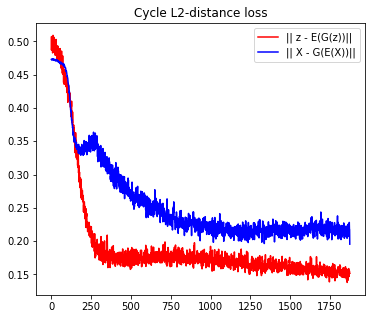

In [0]:

start_time = time.time()

step = 0
epochs = 2
overall_loss_d = []
overall_loss_g = []

l2_x = []
l2_z = []

saved_generator_imgs = [] # saves one image each episode
generator_predictions = [] # saves the predictions of the discriminator to the fake images
for epoch in range(epochs):
    episodic_loss_d = []
    episodic_loss_g = []

    for idx, batch in enumerate(data_loader):
        
        generator.train()
        encoder.train()
        generator.zero_grad()
        encoder.zero_grad()
        discriminator.zero_grad()
        optimizer_G.zero_grad()
        x, y = batch 
        #zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        zn, zc, zc_idx = sample_z(latent_dim=latent_space_zn, shape=BATCH_SIZE)

        x_fake = generator(zn.to(device),zc.to(device)) # create fake imgs
        pred_real = discriminator(x.to(device))
        pred_fake = discriminator(x_fake)
        
        enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encoder(x_fake)
        
        #Train Generator
        # calc losses:        
        zn_loss = mse_loss(enc_gen_zn, zn.to(device))
        zc_loss = cross_entropy_loss(enc_gen_zc_logits, zc_idx.to(device))        

        # generator loss
        beta_n = 10
        beta_c = 10
        g_loss = torch.mean(pred_fake) + beta_n * zn_loss + beta_c * zc_loss   # value 10 depents on nr of classes
        g_loss.backward(retain_graph=True)
        optimizer_G.step()
        episodic_loss_g.append(g_loss.item())         
        
        torch.autograd.set_detect_anomaly(True)
        #Train Discriminator
        optimizer_D.zero_grad()
        grad_penalty = calc_gradient_penalty(discriminator, x.to(device), x_fake)
        loss_d = torch.mean(pred_real) - torch.mean(pred_fake) + grad_penalty
        loss_d.backward()
        optimizer_D.step()
        episodic_loss_d.append(loss_d.item())
        
        generator.eval()
        encoder.eval()
        
        if idx == 0:
            # Saves the first produced image each episode
            random_nr = np.random.random_integers(0,BATCH_SIZE-1)
            saved_generator_imgs.append(deprocess(x_fake[random_nr]))
            generator_predictions.append(pred_fake[random_nr])
    
        step += 1
        
        #### Calc L2-distance loss
        ### || z - E(G(z)) || and || X - G(E(X))||
        z = torch.cat((zn,zc), dim = 1)
        E_G_z = torch.cat((enc_gen_zn, enc_gen_zc), dim = 1)
        z_error = abs(z.detach().cpu().numpy() - E_G_z.detach().cpu().numpy()).mean()
        l2_z.append(z_error)
        
        X_zn, X_zc, X_id = encoder(x.to(device))
        G_E_X = generator(X_zn, X_zc).squeeze(1)
        X_error = np.sqrt((x.numpy()-G_E_X.detach().cpu().numpy())**2).mean()     
        l2_x.append(X_error)
        
        if epoch == 0 and idx ==0:
            overall_loss_g.append(np.array(episodic_loss_g).mean())
            overall_loss_d.append(np.array(episodic_loss_d).mean())
        ##### Monitoring:
        
        print("\rDiscriminator loss: {} || Batch Generator loss {} || Epoch {}".format(round(loss_d.detach().cpu().numpy().mean(),2), round(g_loss.detach().cpu().numpy().mean(),2), epoch), end = "")
        sys.stdout.flush()
        
              
    overall_loss_g.append(np.array(episodic_loss_g).mean())
    overall_loss_d.append(np.array(episodic_loss_d).mean())
    print("\nEpisode: {} -- Discriminator loss: {} -- Generator loss: {}".format(epoch, np.array(episodic_loss_d).mean(), np.array(episodic_loss_g).mean()))
    
    plot(epoch, l2_z, l2_x)

end_time = time.time()

# Training Statistics and Visuals

Training took 2.522298733393351 min


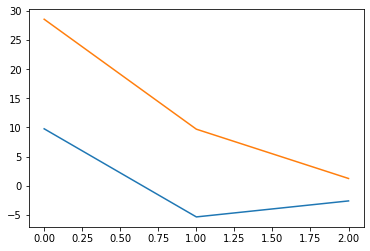

In [0]:
print("Training took {} min".format((end_time-start_time)/60))
plt.plot(overall_loss_d)
plt.plot(overall_loss_g)
plt.show()

In [0]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)

In [0]:
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(data_loader))
    imgs_.append(imgs)
    labels_.append(labels)
imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

enc_zn, enc_zc, enc_zc_logits = encoder(imgs.to(device))
enc = np.hstack((enc_zn.cpu().detach().numpy(), enc_zc_logits.cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.022s...
[t-SNE] Computed neighbors for 6400 samples in 2.602s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 2.543715
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.680435
[t-SNE] KL divergence after 1000 iterations: 2.142194


In [0]:
enc.shape

(6400, 40)

In [0]:
enc[:,0:2]

array([[-0.38177732,  0.24782239],
       [ 0.09144006, -0.12641004],
       [ 1.070578  , -0.18633473],
       ...,
       [ 0.3347302 , -0.05407168],
       [ 1.182723  , -0.20502712],
       [ 0.69204754,  0.01381668]], dtype=float32)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

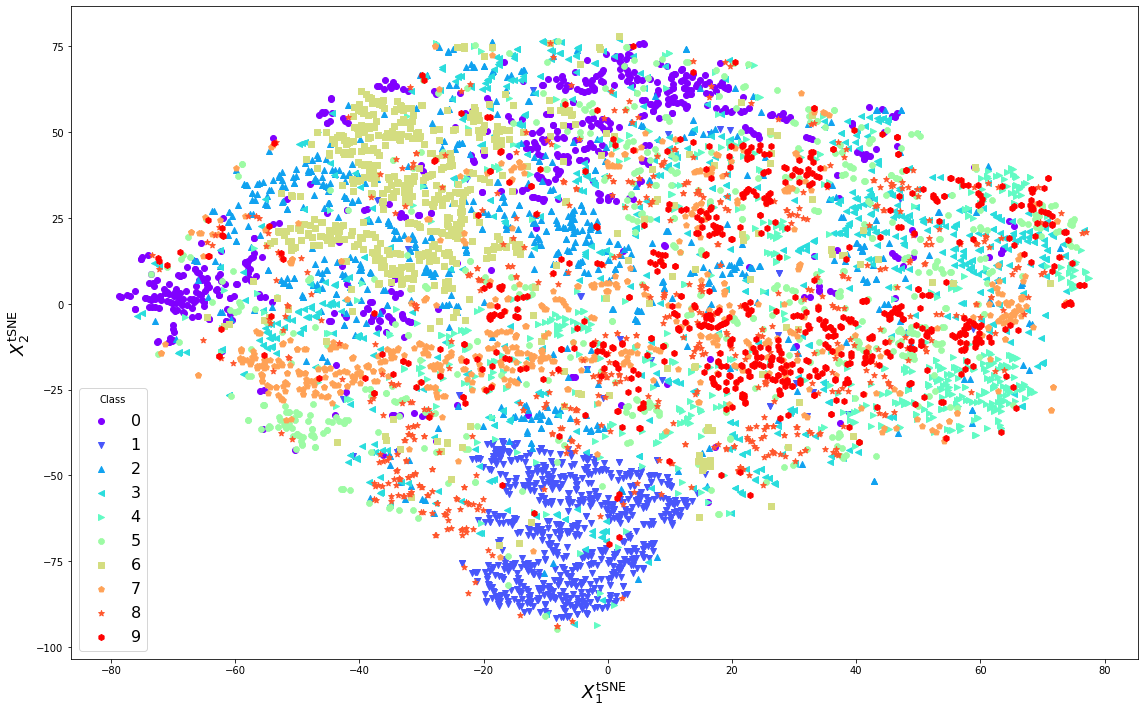

In [0]:
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    #ax.set_title(r'%s'%fig_title, fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()
    fig.savefig('tsne-pca.png')

# Natural Clustering


Different values of categorical variables such as object classes (e.g. cats , dogs) tend to be associated with separate manifolds. Each manifold is composed of learned representation of an object class (say dog, cat). So moving along a manifold tends to preserve the value of a category (e.g. variations of dog when moving on the “dog” manifold). Interpolating across object classes would require going through a low density region separating the manifolds. In essence, manifolds representing object classes tend not to overlap much. This factor is exploited in machine learning.

### Spectral Clustering Results

In [0]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=10,assign_labels="discretize",random_state=0).fit(enc[:,0:2])
clustering.labels_

array([9, 9, 4, ..., 9, 4, 4])

### Mean-Shift Clustering

In [0]:
from sklearn.cluster import MeanShift
clustering = MeanShift().fit(enc)

cluster_centers = clustering.cluster_centers_


Latent Space Dimension = 37


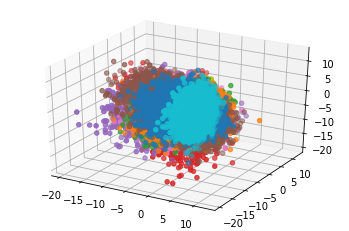

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
latent_space_dim = 37
print("Latent Space Dimension = "+str(latent_space_dim))
for i in range(latent_space_dim):
  ax.scatter(enc[:,i], enc[:,i+1], enc[:,i+2], marker='o')
  ax.scatter(cluster_centers[:,i], cluster_centers[:,i+1], cluster_centers[:,i+2], marker='x', color='red', s=300, linewidth=5, zorder=10)
plt.savefig('dimension_coherence.png')

### Aggolomerative Clustering

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

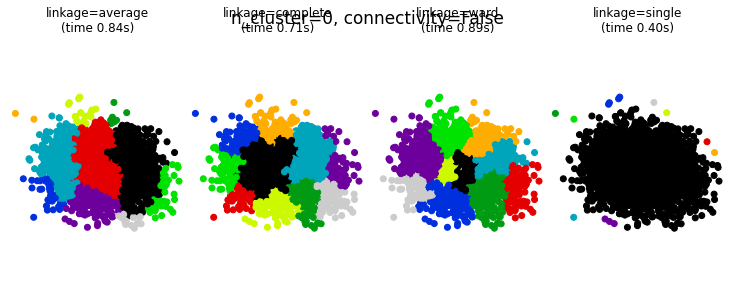

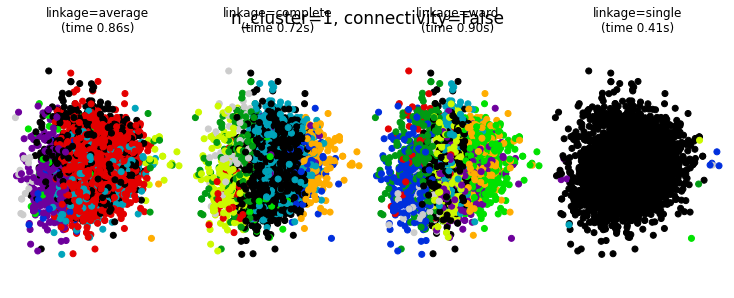

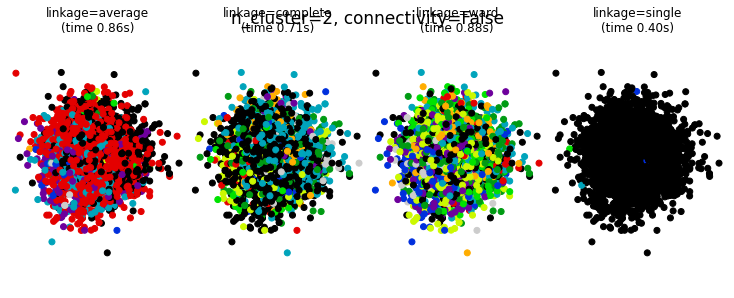

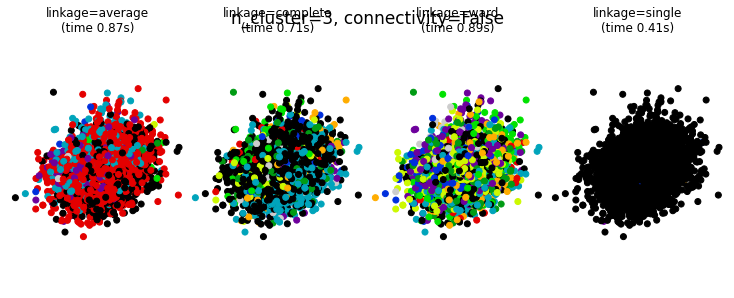

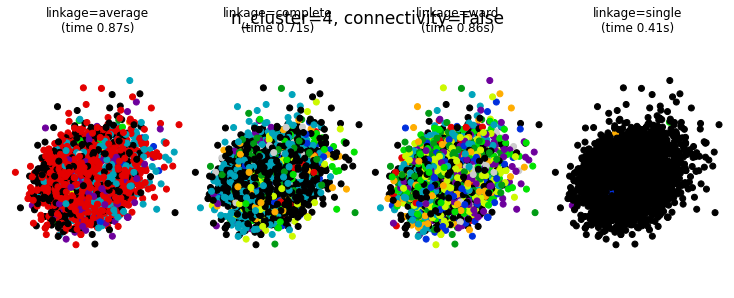

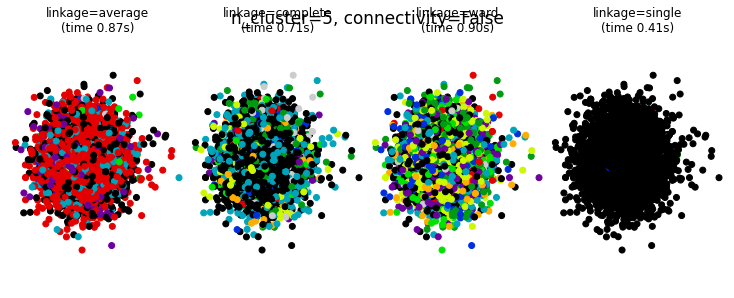

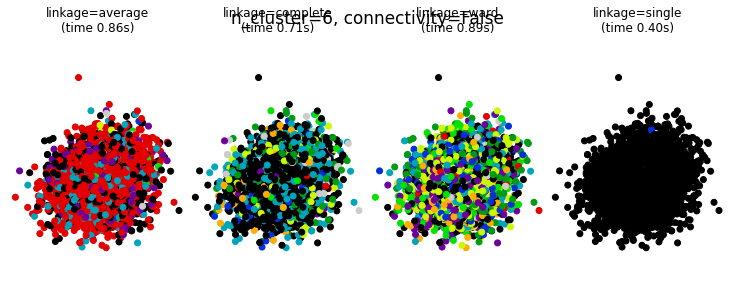

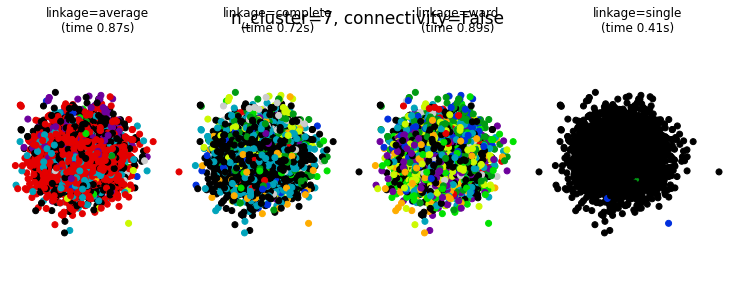

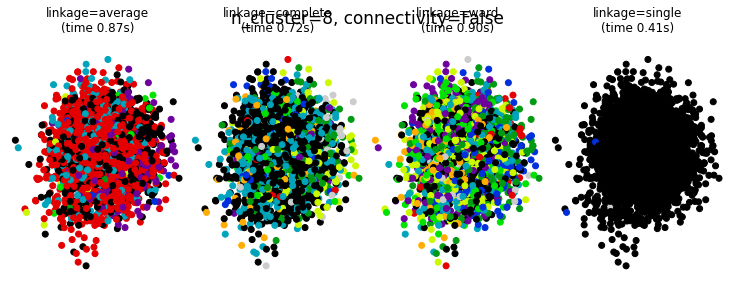

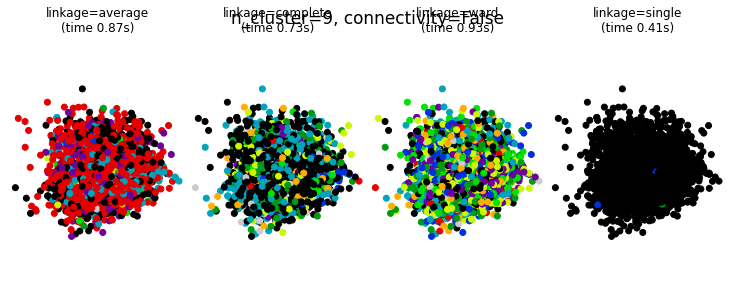

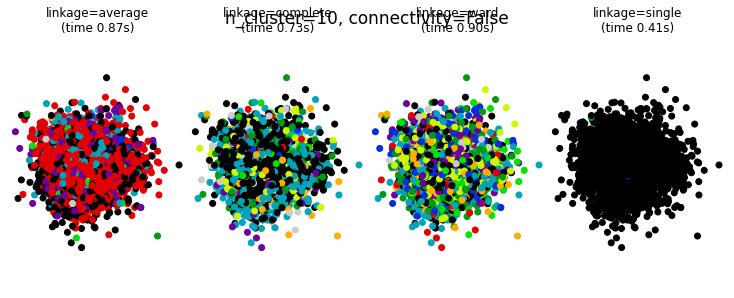

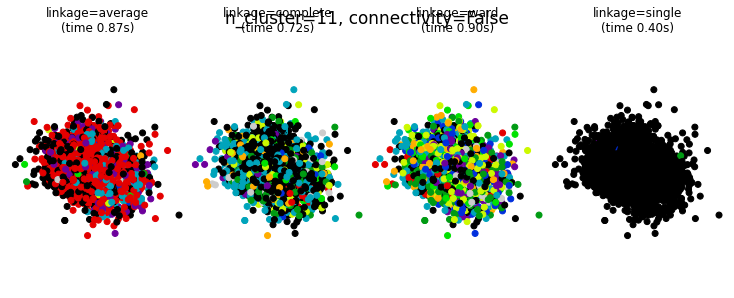

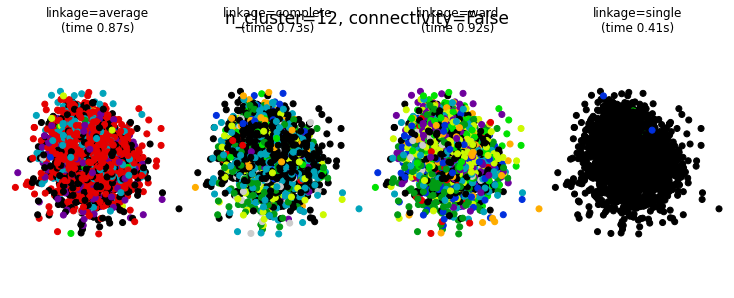

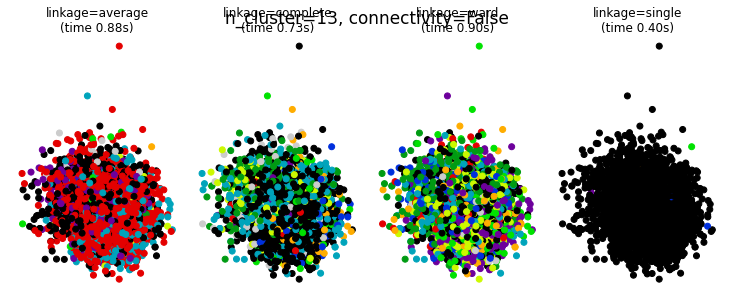

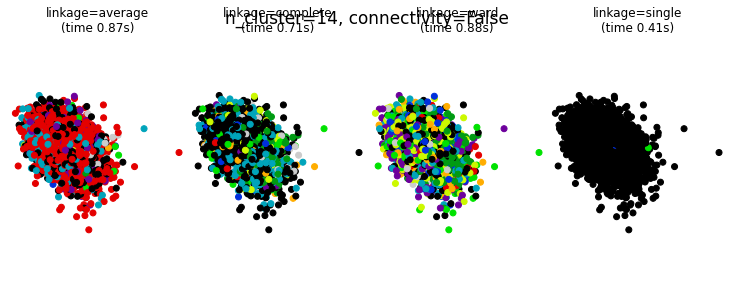

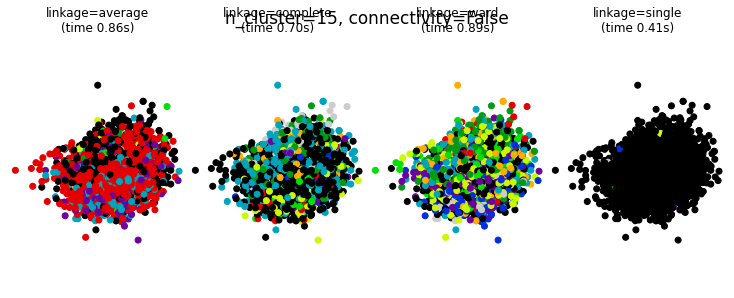

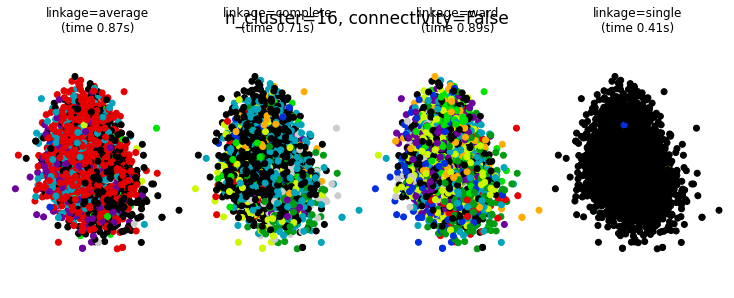

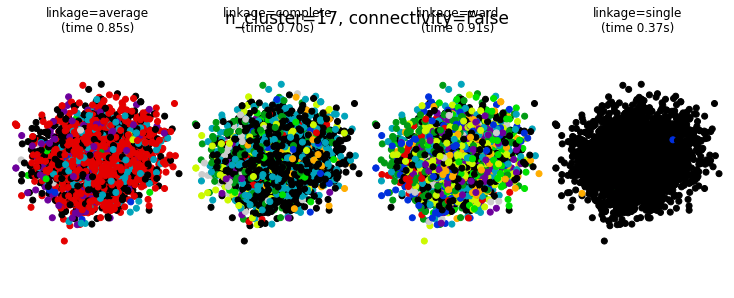

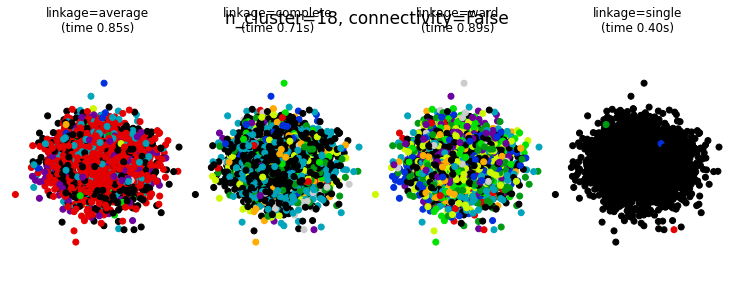

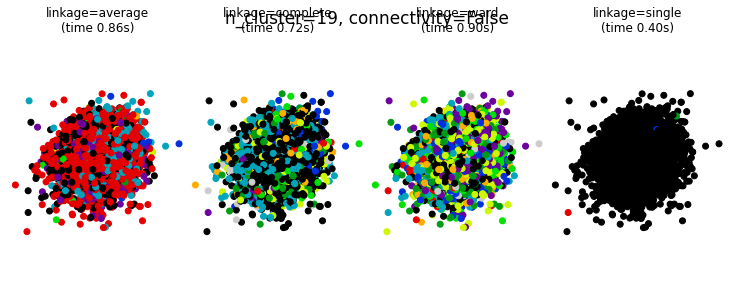

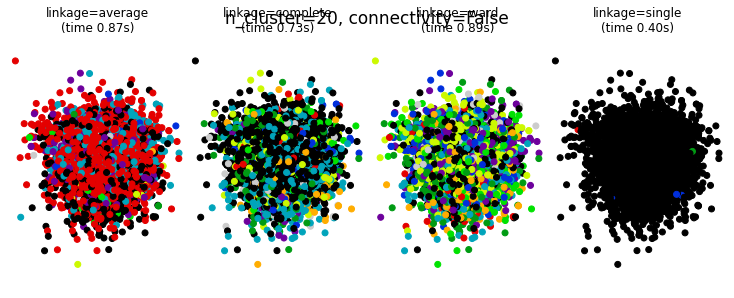

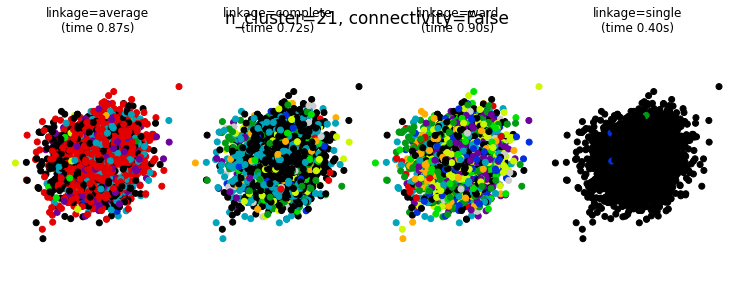

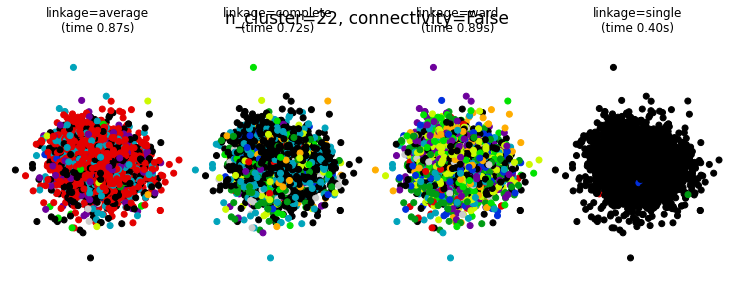

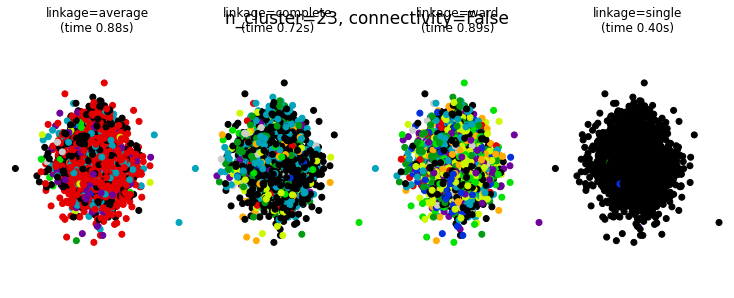

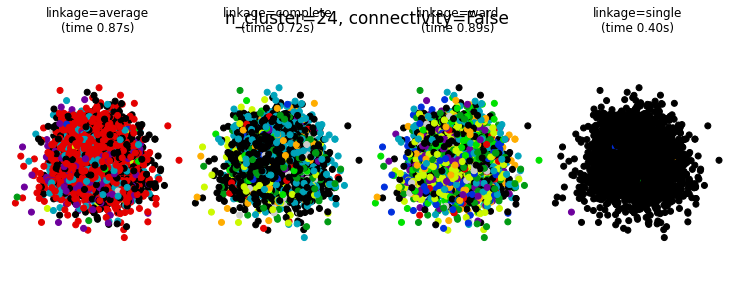

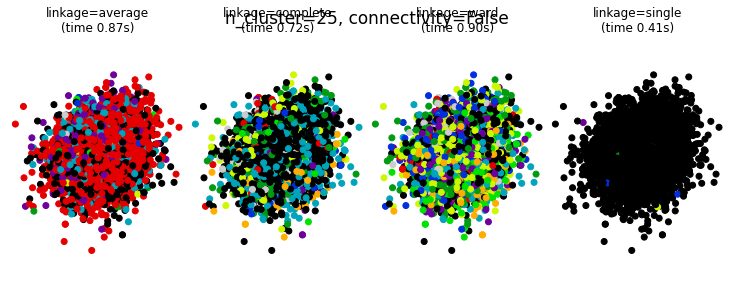

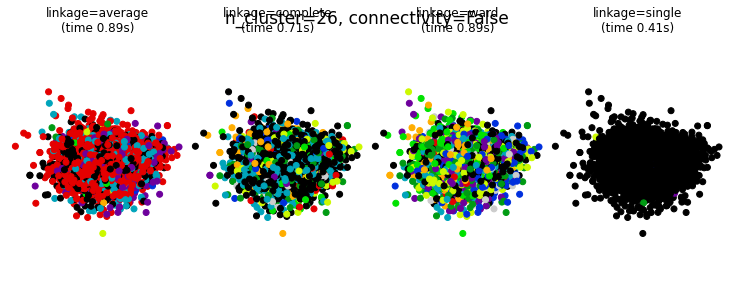

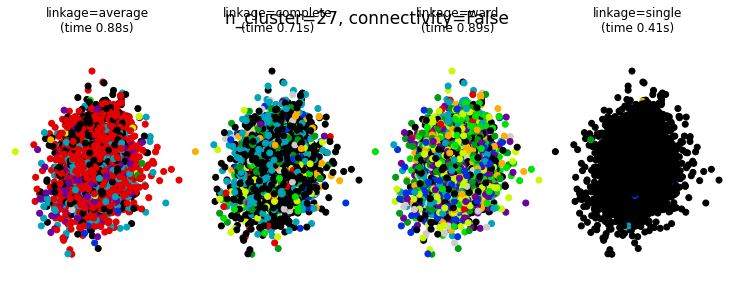

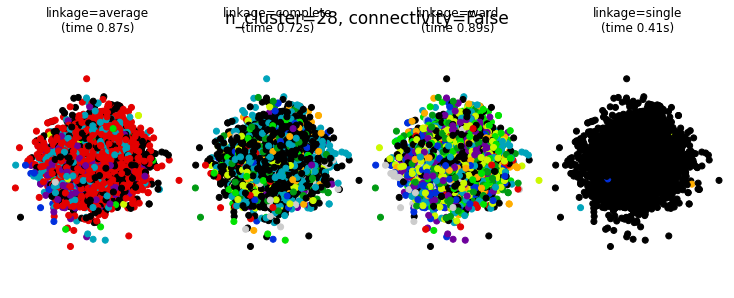

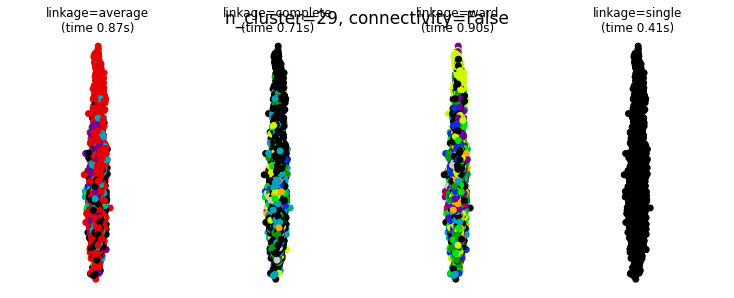

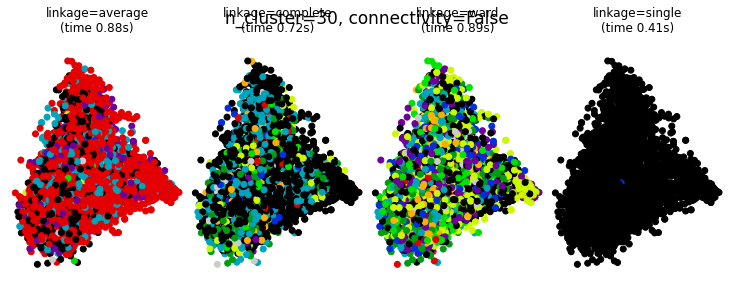

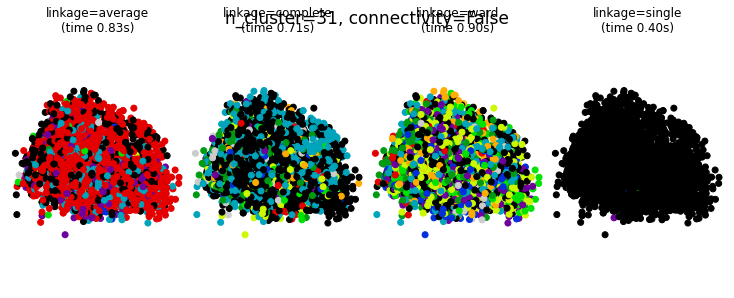

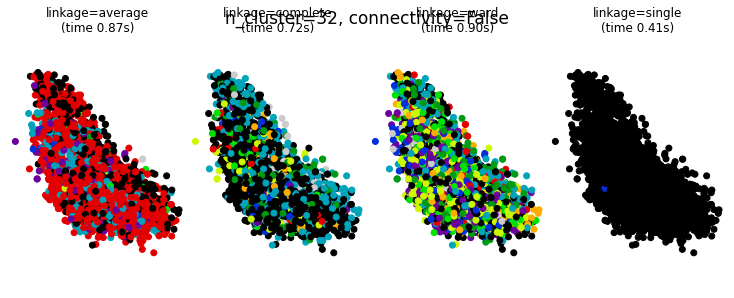

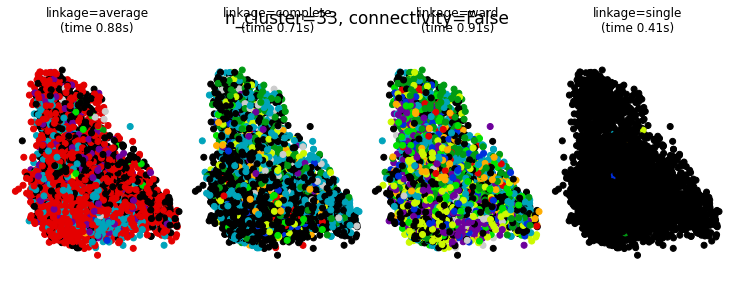

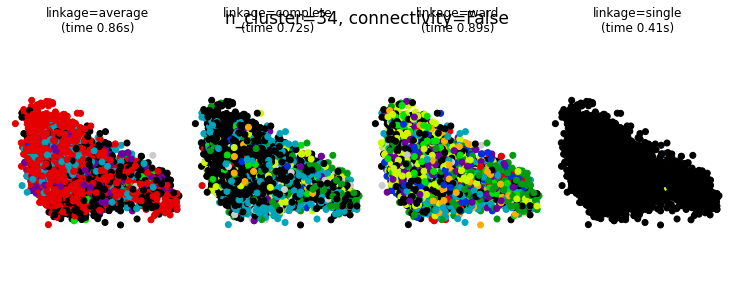

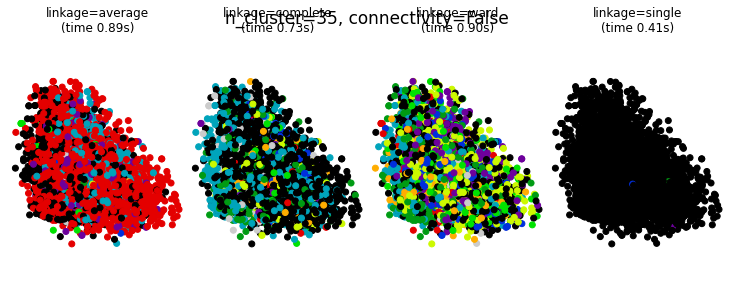

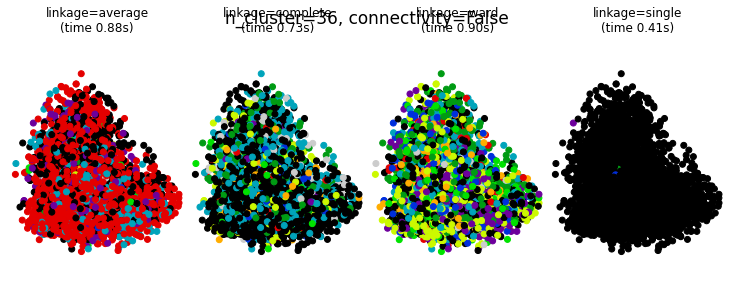

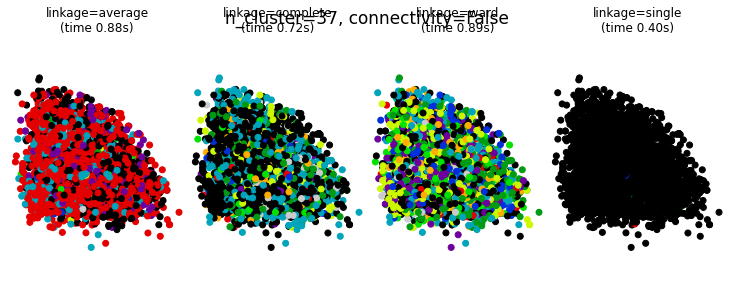

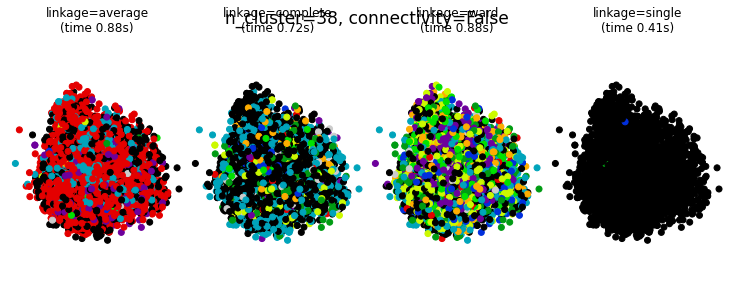

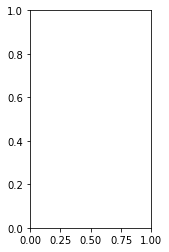

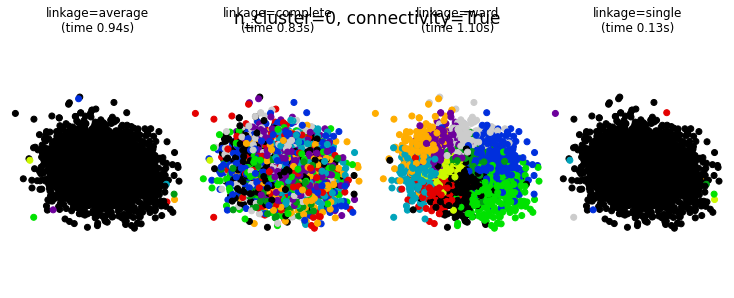

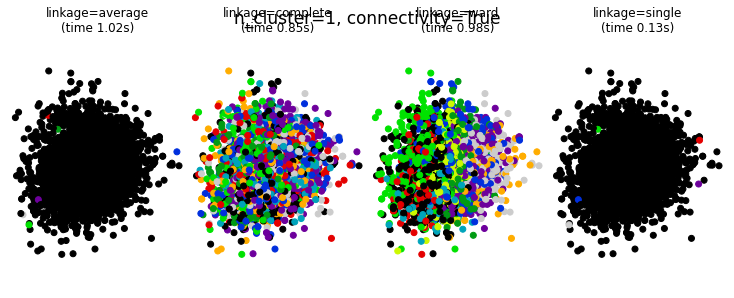

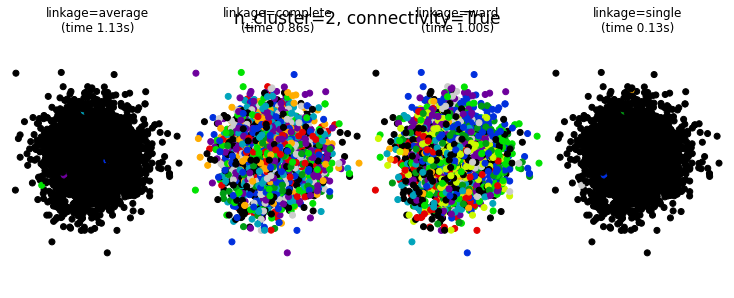

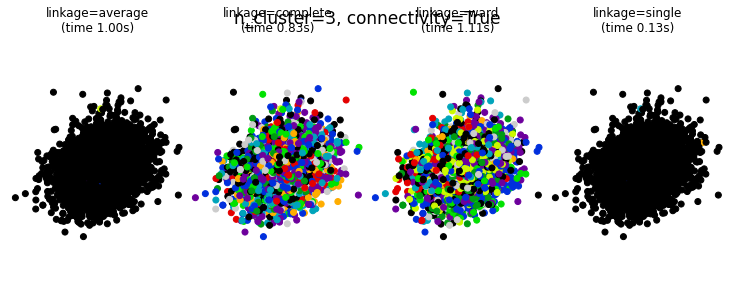

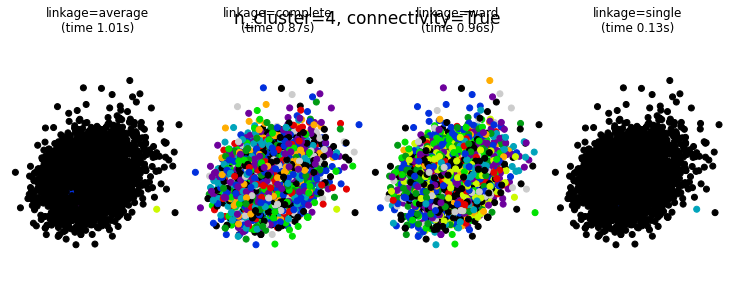

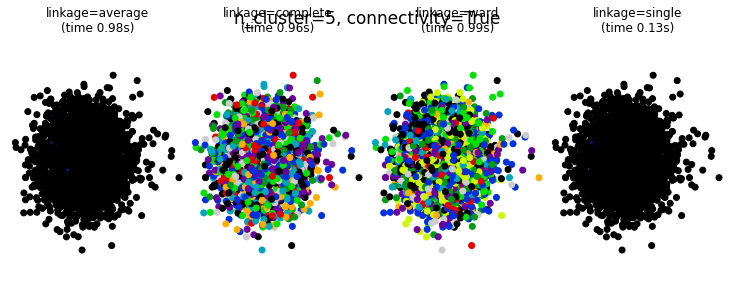

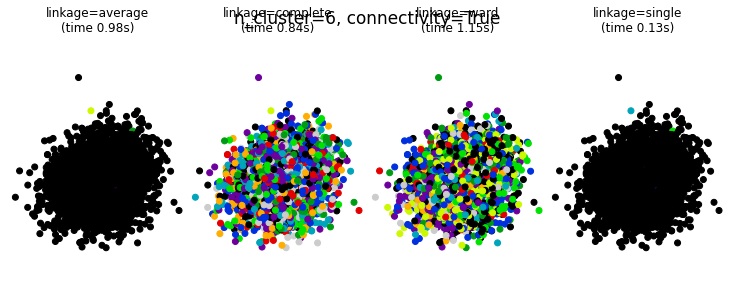

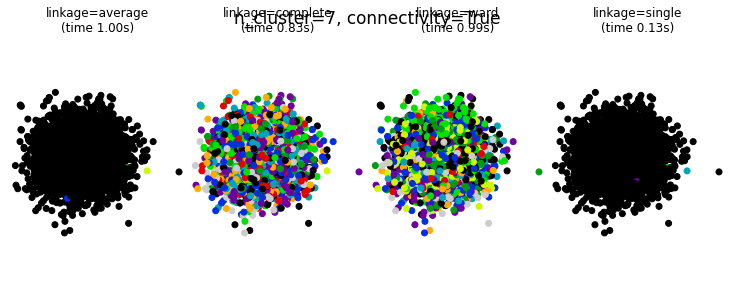

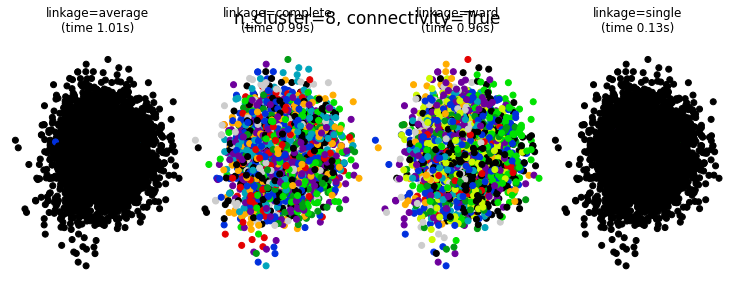

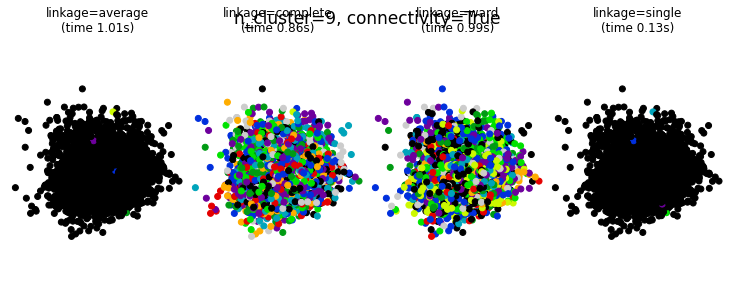

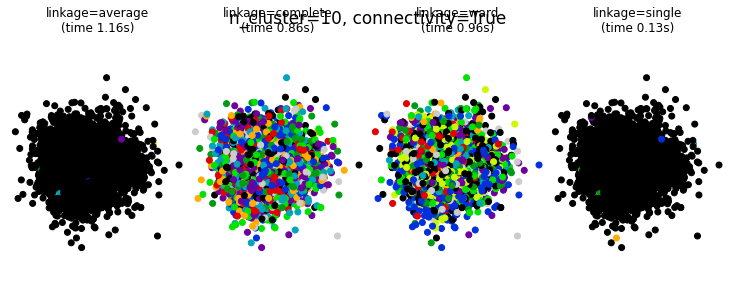

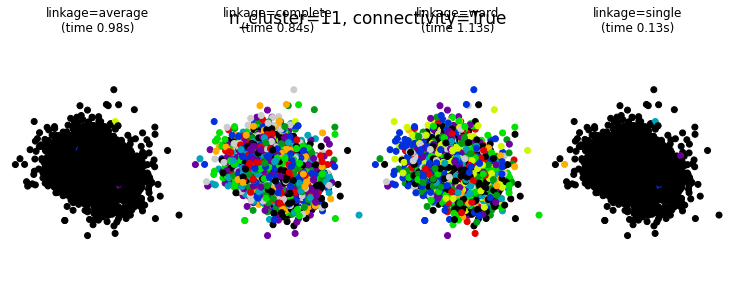

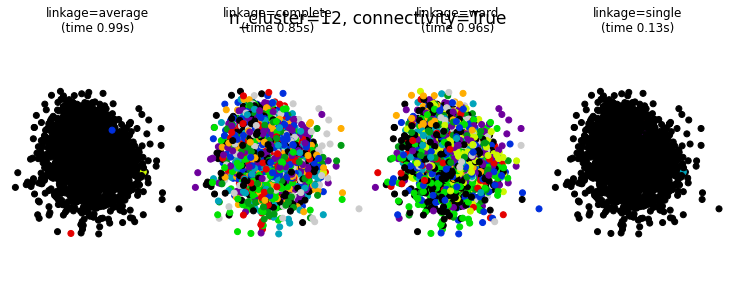

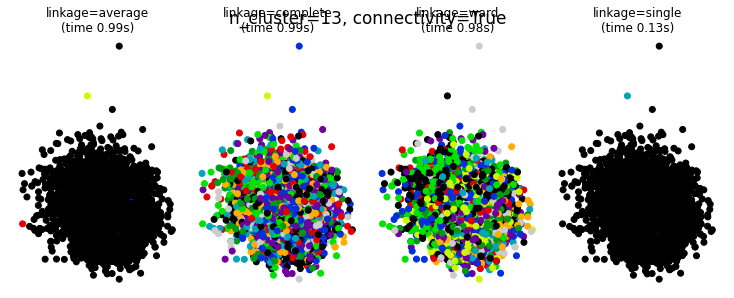

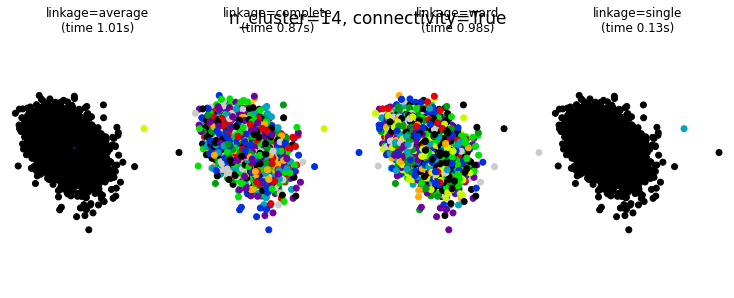

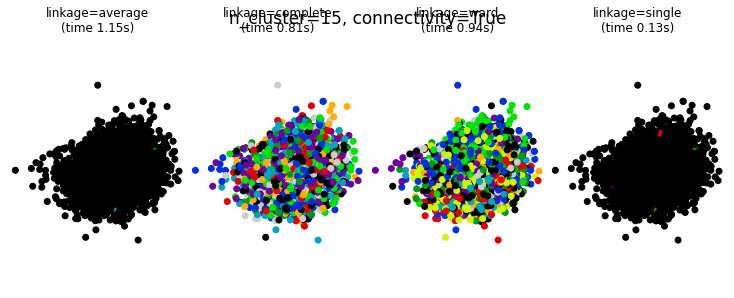

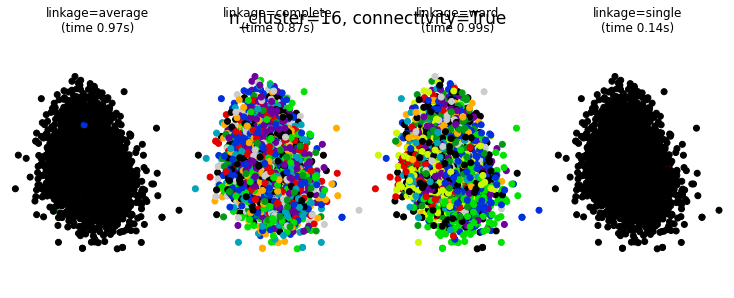

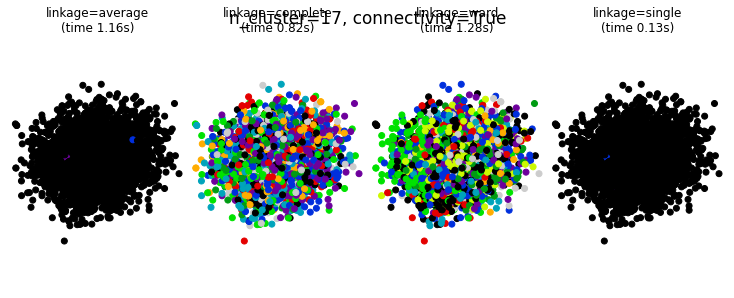

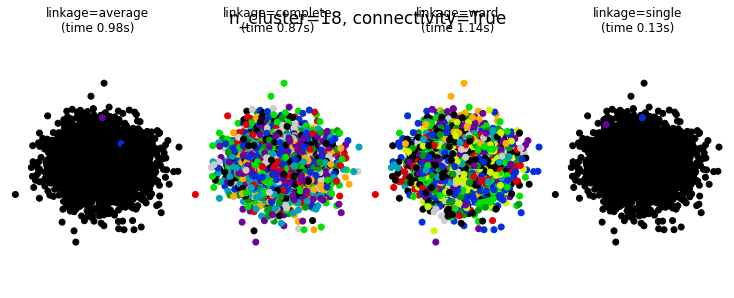

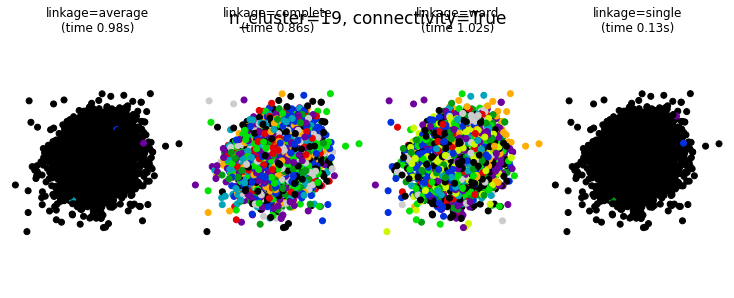

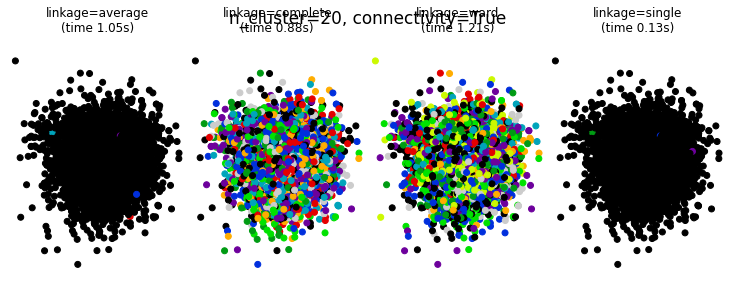

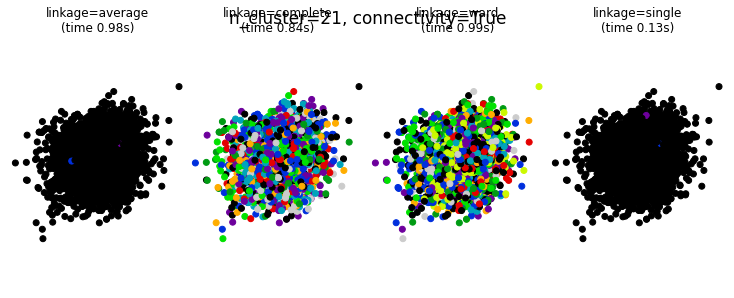

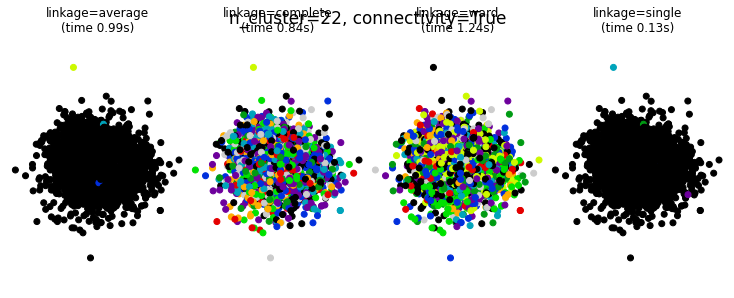

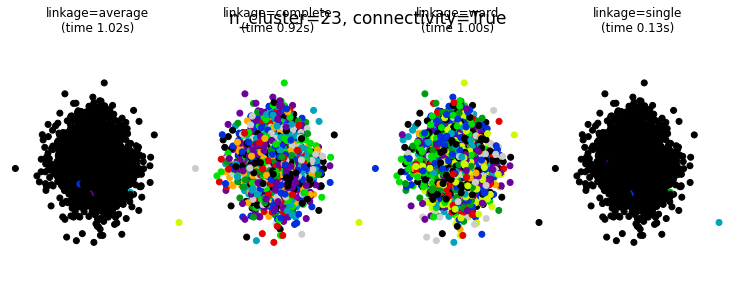

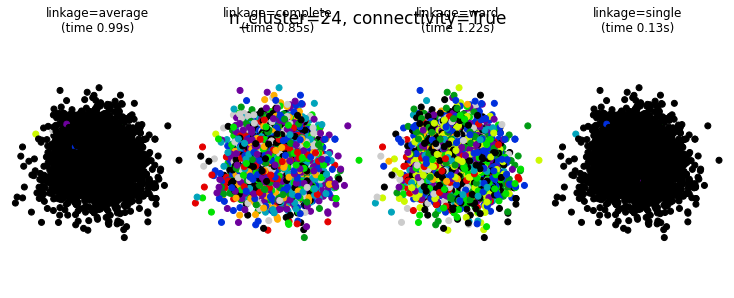

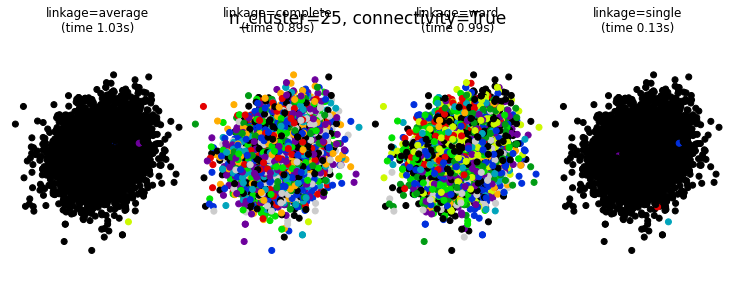

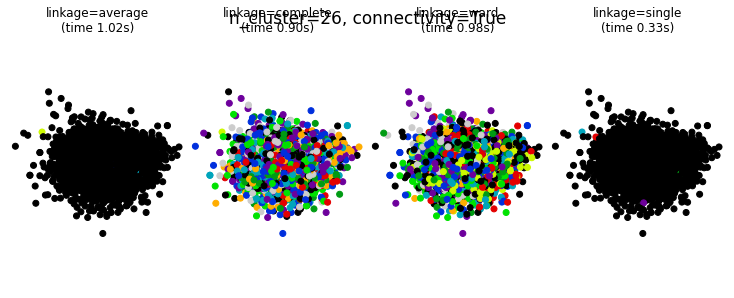

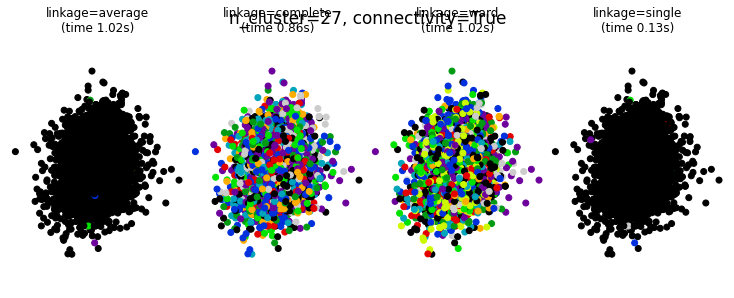

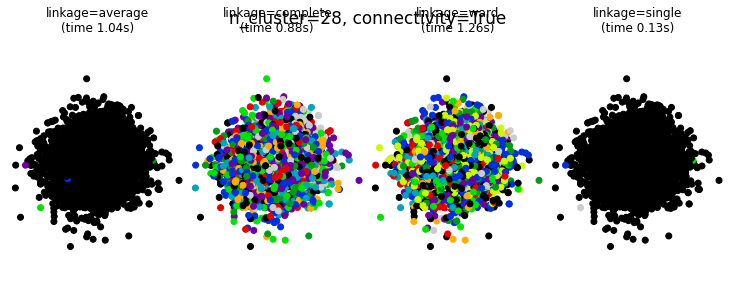

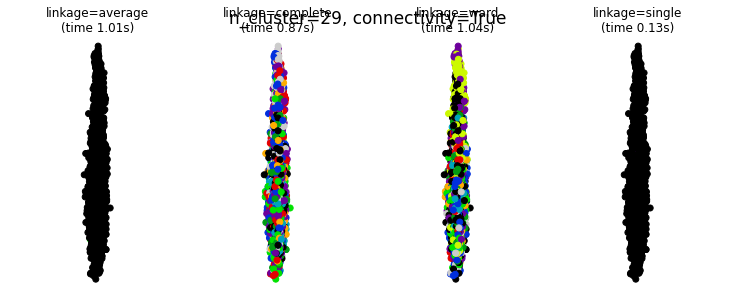

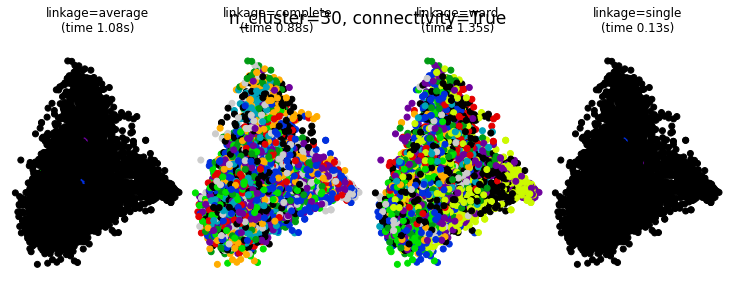

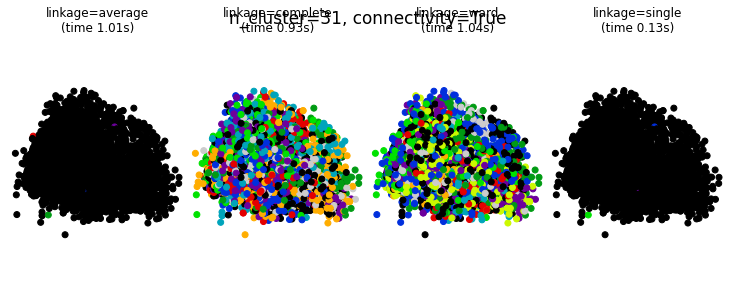

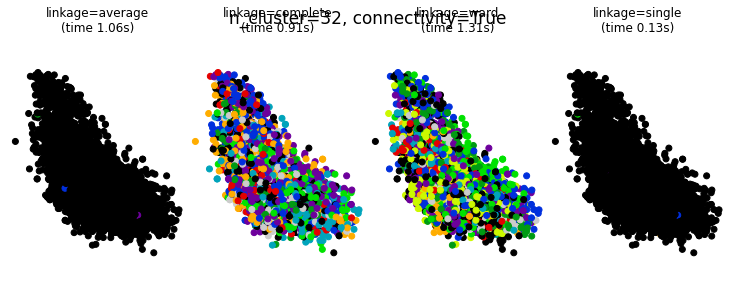

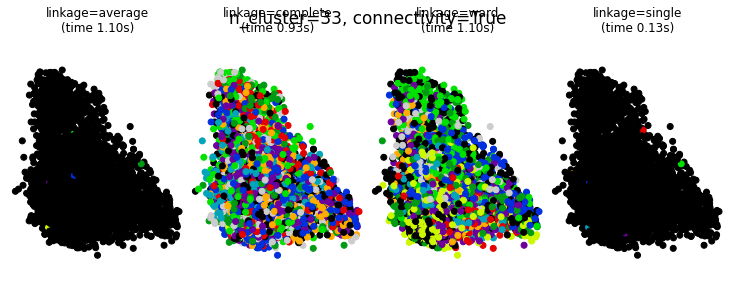

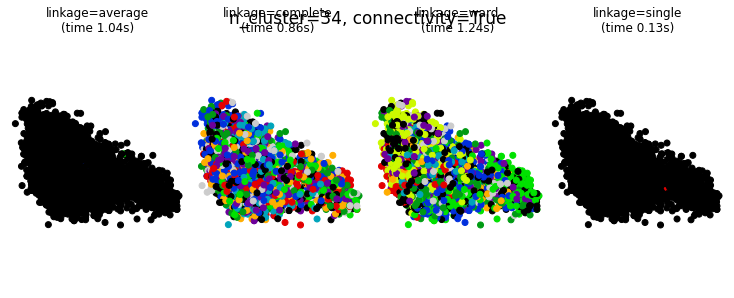

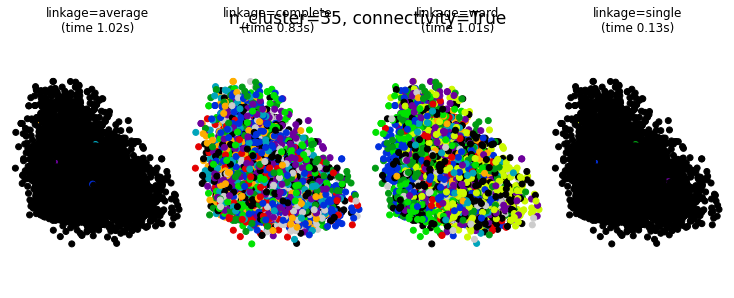

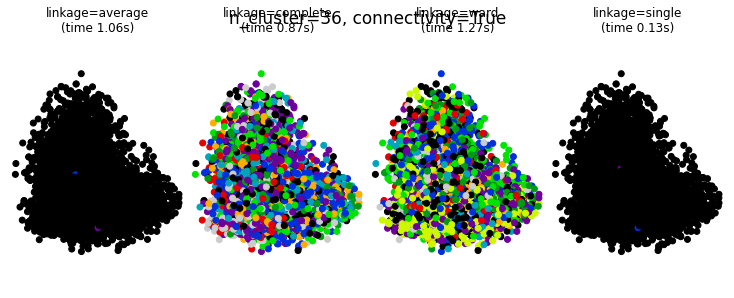

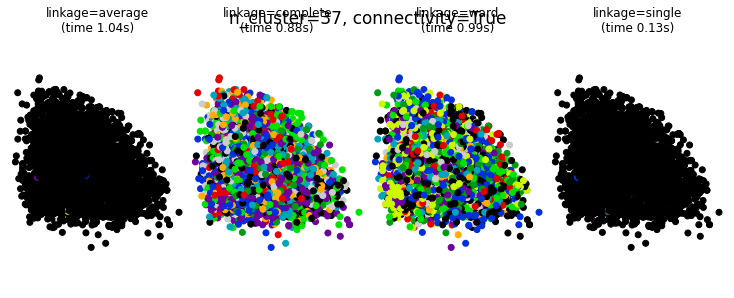

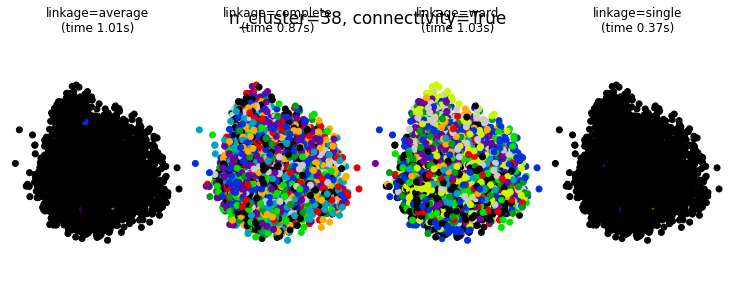

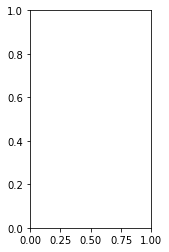

In [0]:
import time
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

knn_graph = kneighbors_graph(enc, 10, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in range(40):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=10)
            t0 = time.time()
            model.fit(enc[:,0:2])
            elapsed_time = time.time() - t0
            if n_clusters == 39:
              break
            else:
              plt.scatter(enc[:, n_clusters], enc[:, n_clusters+1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
              plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
              plt.axis('equal')
              plt.axis('off')

              plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
              plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.savefig('research_results.png', bbox_inches='tight')

# Manifold Learning on the Learned Latent Space Vectors

Even though input data for AI tasks such as image, text, audio reside in a high dimensional space (e.g. 28x28 black and white image has 784 degrees of freedom yielding  2784  possible images), most uniformly sampled output (for instance sampling from those  2784 possible images) would not be naturally occurring images. The basic idea of manifold hypothesis is that there exists a lower dimensional manifold in which these naturally occurring images actually lie. So the model learning task becomes learning to output representations that map the naturally occurring images in the high dimensional input space to the low dimensional manifold. The idea is that the small variations of the naturally occurring images (e.g. rotations) etc are mapping to corresponding changes in the learned representation (see figure above) in the low dimensional manifold. PCA is an example of a manifold mapping algorithm where the manifold is linear. Autoencoders are inspired by the manifold hypothesis and learn lower dimensional representations of high dimensional data. Even though autoencoders are known to perform dimensionality reduction, the manifold view gives a deeper understanding of this mapping.

### Spectral Embedding diagram

Generating embedding
Dimensions for the manifold reduction : 2
ward :	0.90s
average :	1.00s
complete :	0.81s
single :	0.39s


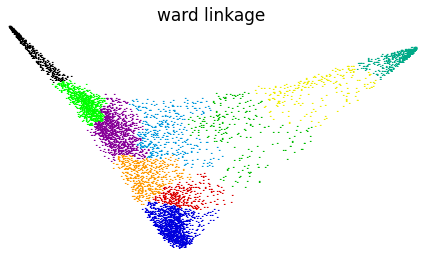

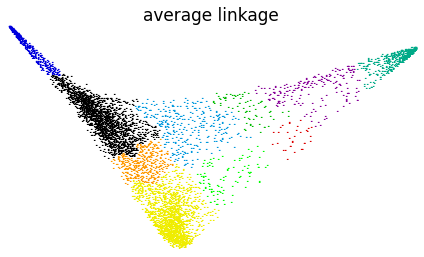

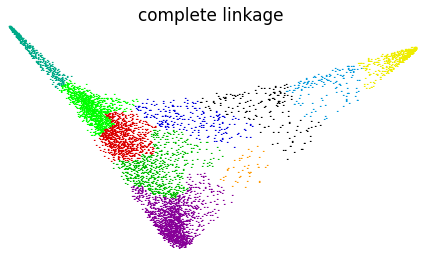

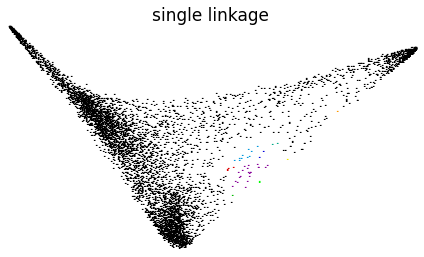

In [0]:
from time import time
from sklearn import manifold

def make_manifolds(encoder_manifold, labels, title=None):
    manifold_discriminant, manifold_normal = np.min(encoder_manifold, axis=0), np.max(encoder_manifold, axis=0)
    encoder_manifold = (encoder_manifold - manifold_discriminant) / (manifold_normal - manifold_discriminant)

    plt.figure(figsize=(6, 4))
    for idx in range(encoder_manifold.shape[0]):
        plt.text(encoder_manifold[idx, 0], encoder_manifold[idx, 1], '.',
                 color=plt.cm.nipy_spectral(labels[idx] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


print("Generating embedding")
dimension_to_be_reduced = 2
print("Dimensions for the manifold reduction : "+str(dimension_to_be_reduced))

encoder_latent_z = manifold.SpectralEmbedding(n_components=dimension_to_be_reduced).fit_transform(enc)


from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete', 'single'):
    manifiold_clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    manifiold_clustering.fit(encoder_latent_z)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    make_manifolds(encoder_latent_z, manifiold_clustering.labels_, "%s linkage" % linkage)

plt.savefig('research_results_manifolds.png')

# Generate model files

This is for other researchers to replicate my results. I have made both PTH model and ONNX models. Both these are heavily used in academic research.

In [0]:
torch.save({
            'generator_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'generator_optimizer_state_dict': optimizer_G.state_dict(),
            'discriminator_optimizer_state_dict': optimizer_D.state_dict()
            },'cluster_gan_.pth')

In [0]:
torch.save(generator.state_dict(),'cluster_gan_generator.pth')
torch.save(discriminator.state_dict(),'cluster_gan_discriminator.pth')
torch.save(encoder.state_dict(),'cluster_gan_encoder.pth')

In [0]:
for idx, batch in enumerate(data_loader):
        if idx == 1:
          break
        generator.train()
        encoder.train()
        generator.zero_grad()
        encoder.zero_grad()
        discriminator.zero_grad()
        optimizer_G.zero_grad()
        x, y = batch 
        
        zn, zc, zc_idx = sample_z(latent_dim=latent_space_zn, shape=BATCH_SIZE)

        gen_input = zn.to(device),zc.to(device)
        x_fake = generator(zn.to(device),zc.to(device)) # create fake imgs
        pred_real = discriminator(x.to(device))
        pred_fake = discriminator(x_fake)
        
        enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encoder(x_fake)
        
        # Generator
        state_dict_gen = torch.load('cluster_gan_generator.pth')
        generator.load_state_dict(state_dict_gen)
        torch.onnx.export(generator, (gen_input),"cluster_gan_generator.onnx")

        # Discriminator
        state_dict_dis = torch.load('cluster_gan_discriminator.pth')
        discriminator.load_state_dict(state_dict_dis)
        torch.onnx.export(discriminator, x.to(device),"cluster_gan_discriminator.onnx")

        # Encoder
        state_dict_enc = torch.load('cluster_gan_encoder.pth')
        encoder.load_state_dict(state_dict_enc)
        torch.onnx.export(encoder, x_fake,"cluster_gan_encoder.onnx")

# Future Works - Ergodic Theory

Ergodic theory is a field in mathematics that explores dynamic nature of systems. Ergodic theory studies statistical properties of deterministic changing nature of dynamic systems. In this context we can consider the latent space of GAN as a dynamic system (since it changes every epoch). This theory should be able to track the trajectories of GAN latent space vector system as a function of time. 

This most importantly assumes that the dynamics of the latent space vectors do not contain any random noise or perturbations. This can be a pitfall but, if we can use signal recovery techniques such as compressed sensing theoretically we can explore this as an insight technique for GAN latent space vectors.

![Ergodic Theorem](https://www.johndcook.com/ergodic_theorem.svg)

# Future Works - Temporal and Spatial Coherence

To identify features with a small amount of change in magnitude spatially or temporally could be useful in learning represenations. Various features change at different scales spatially and temporally. BUt values of features of interest change slowly due to the Euclidean nature of the dataset. 

By artificially slowing the scale of fast moving features we can derive insights. We can do this by adding a vector to penalize the change in feature magnitude in a loss function, a regularization technique, or as a function over time and space. Temporal cohenrence has been used previously to model video footage.